<a href="https://colab.research.google.com/github/anubhavsatpathy/EVA/blob/master/Session6/EVA_6_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###50 shades of Convolution!
This part of the assignment asks us to create models using the following kinds of convolution:

- 3x3 vanilla
- 3x3 dialated
- Spatially Separable
- Depthwise Separable
- Grouped (3x3 and 5x5)

All these convolutions need to be utilized at least once



###Importing Modules:

We utilize the code snippen below to import modules to our runtime so that we can use the interfaces exposed by these modules to write and adjust our CNN. We describe only a few modules below that we have not covered in previous assignments:

- **ModelCheckpoint** : This is among the many callbacks provided by Keras that we can use while training our model. We will use this to store the best model weights so that we do not loose out on them by updations performed during subsequent epochs ([Documentation](https://keras.io/callbacks/))

- **ImageDataGenerator** : This module helps us perform image augmentation which is a very strong regularization measure. We can use this to apply transformations like rotation, translation, random crop etc. on out training dataset before passing them on to the network ([Documentation](https://keras.io/preprocessing/image/))

- **Dropout** : This a keras layer that implements dropouts. Dropouts are another regurarization mechanism that drop certain pixel values while training the model so that our model does not overfit to the training images ([Documentation](https://keras.io/layers/core/))

In [0]:
from keras import backend as K
import time
import keras
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D, Concatenate, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


### Loading and Pre-Processing the Data:

Some details about the dataset:

- Name : Cifar10
- Number of classes : 10
- Training set size : 50K
- Test set size : 10K
- Image resolution : 32x32

In the code below, we :

- Load the data extracted from a tar.gz file into python variables *(train_features, test_features , test_labels and train_labels)*
- Each of the images are in shape *[3, 32, 32]* and labels are simple integers


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 13s 0us/step


###Looking at a few examples :

In the code below, we :

- Decode the int labels into class names using a python list

Then for each of our classes we do the following:
- Add a subplot to the figure
- Find the first image in the trainset with that label 
- Plot that image to the subplot
- Set the class name as the title of the subplot



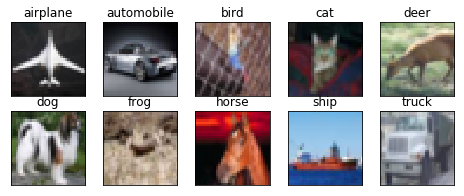

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Plotting model history:

In the code below, we define a utility function that takes the history returned by the *fit_generator()* function and plots the record of the accuracies and losses:

- Plot the train and test accuracies recorded after every epoch
- Plot the train and test losses recorded after every epoch


In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

###Getting the accuracy:

The code below defines a utility function that calculates the accuracy given:

- Training Images of shape *(batch_size, height, width, num_channels)*
- Training labels of shape *(batch_size, num_classes)*
- Returns accuracy in percentage


In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

###Processing the data:

We do the following in the code below:

- Convert image matrices to float
- Encode the labels in a One hot format

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

###Defining our model:

In the code below, we define our model and plot our model:

- We create a model using the functional API of keras
- We use 2 inception like blocks
- The first block uses spatially separable convolutions
- The second block uses depthwise separable convolutions
- Outputs are concatenated at the end of the blocks
- The output of block 1 is passed to block 2 after a bottlenect layer
- After Block 2, we use a few convolution layers and GAP before using softmax
- The model contains about 2403K parameters

W0903 15:40:27.989234 140647130421120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 15:40:28.031624 140647130421120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 15:40:28.039056 140647130421120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 15:40:28.070142 140647130421120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0903 15:40:28.071133 1406471304

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 32)   2400        input_1[0][0]                    
____________________________________________________________________________________________

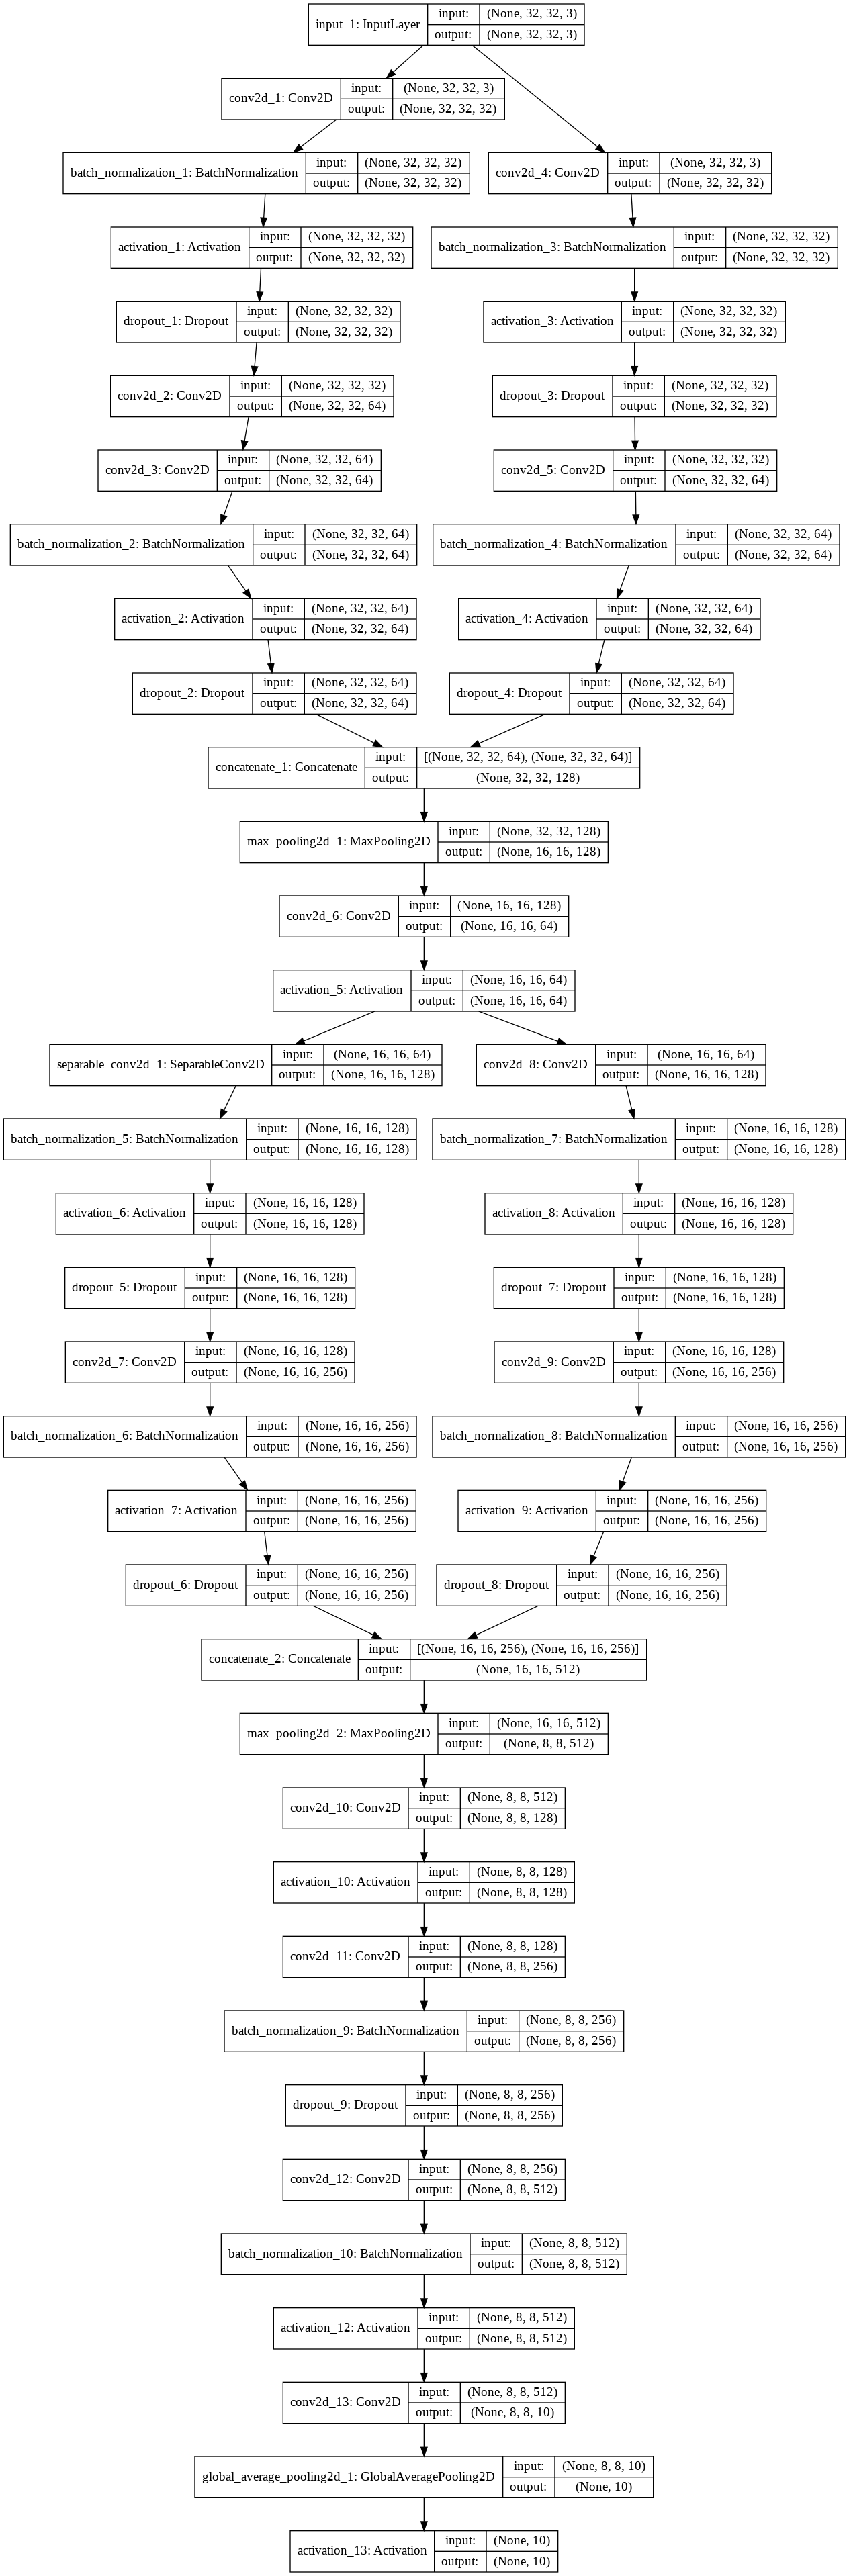

In [0]:
from keras.regularizers import l2
from keras.layers import Input, SeparableConv2D, Conv1D



input = Input(shape = (32,32,3))

#Defining block 1

conv1 = Conv2D(32,(3,3),padding = 'same', use_bias = False)(input)
bn1 = BatchNormalization()(conv1)
relu1 = Activation('relu')(bn1)
do1 = Dropout(0.05)(relu1)
conv2 = Conv2D(64, (1,3), padding = 'same', use_bias = False)(do1)
conv3 = Conv2D(64, (3,1), padding = 'same', use_bias = False)(conv2)
bn2 = BatchNormalization()(conv3)
relu2 = Activation('relu')(bn2)
do2 = Dropout(0.05)(relu2)
conv4 = Conv2D(32,(5,5), padding = 'same', use_bias = False)(input)
bn3 = BatchNormalization()(conv4)
relu3 = Activation('relu')(bn3)
do3 = Dropout(0.05)(relu3)
conv5 = Conv2D(64, (3,3), padding = 'same', use_bias = False, dilation_rate = (2,2))(do3)
bn4 = BatchNormalization()(conv5)
relu4 = Activation('relu')(bn4)
do4 = Dropout(0.05)(relu4)
concat1 = Concatenate(axis = 3)([do2,do4])

mp11 = MaxPooling2D(2,2)(concat1)
pointwise1 = Conv2D(64,(1,1), padding = 'same', use_bias = False)(mp11)
relup1 = Activation('relu')(pointwise1)

#Defininf block 2

conv6 = SeparableConv2D(128,(3,3),padding = 'same', use_bias = False)(relup1)
bn5 = BatchNormalization()(conv6)
relu5 = Activation('relu')(bn5)
do5 = Dropout(0.05)(relu5)
conv7 = Conv2D(256, (3,3), padding = 'same', use_bias = False)(do5)
bn6 = BatchNormalization()(conv7)
relu6 = Activation('relu')(bn6)
do6 = Dropout(0.05)(relu6)
conv8 = Conv2D(128,(5,5), padding = 'same', use_bias = False)(relup1)
bn7 = BatchNormalization()(conv8)
relu7 = Activation('relu')(bn7)
do7 = Dropout(0.05)(relu7)
conv9 = Conv2D(256, (3,3), padding = 'same', use_bias = False, dilation_rate = (2,2))(do7)
bn8 = BatchNormalization()(conv9)
relu8 = Activation('relu')(bn8)
do8 = Dropout(0.05)(relu8)
concat2 = Concatenate(axis = 3)([do6,do8])

mp12 = MaxPooling2D(2,2)(concat2)
pointwise2 = Conv2D(128,(1,1), padding = 'same', use_bias = False)(mp12)
relup2 = Activation('relu')(pointwise2)

conv10 = Conv2D(256, (3,3), padding = 'same', use_bias = False)(relup2)
bn9 = BatchNormalization()(conv10)
relu9 = Activation('relu')(bn9)
do9 = Dropout(0.02)(bn9)
conv11 = Conv2D(512, (3,3), padding = 'same', use_bias = False)(do9)
bn10 = BatchNormalization()(conv11)
relu10 = Activation('relu')(bn10)

pointwise3 = Conv2D(10,(1,1), padding = 'same', use_bias = False)(relu10)

gap1 = GlobalAveragePooling2D()(pointwise3)
softmax = Activation('softmax')(gap1)


model = keras.Model(inputs = input, outputs = softmax)


print(model.summary())
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

  


###Training our model:

We use the following steps to train our better model:

- We **normalize** the train and test images before passing them through the network
- We **save the best** model obtained after each epoch
- The best model thus obtained gives us an accuracy of 88.11%

W0903 15:43:14.834134 140647130421120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1000, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., epochs=50)`
W0903 15:43:15.246161 14064713042112

Epoch 1/50
1000/1000 [==============================] - 112s 112ms/step - loss: 1.0504 - acc: 0.6238 - val_loss: 0.9699 - val_acc: 0.6697

Epoch 00001: val_acc improved from -inf to 0.66970, saving model to best_model.hdf5
Epoch 2/50
1000/1000 [==============================] - 105s 105ms/step - loss: 0.6092 - acc: 0.7877 - val_loss: 0.8573 - val_acc: 0.7184

Epoch 00002: val_acc improved from 0.66970 to 0.71840, saving model to best_model.hdf5
Epoch 3/50
1000/1000 [==============================] - 105s 105ms/step - loss: 0.4736 - acc: 0.8351 - val_loss: 0.5395 - val_acc: 0.8155

Epoch 00003: val_acc improved from 0.71840 to 0.81550, saving model to best_model.hdf5
Epoch 4/50
1000/1000 [==============================] - 105s 105ms/step - loss: 0.3820 - acc: 0.8669 - val_loss: 0.6576 - val_acc: 0.7949

Epoch 00004: val_acc did not improve from 0.81550
Epoch 5/50
1000/1000 [==============================] - 105s 105ms/step - loss: 0.3211 - acc: 0.8878 - val_loss: 0.7855 - val_acc: 0.769

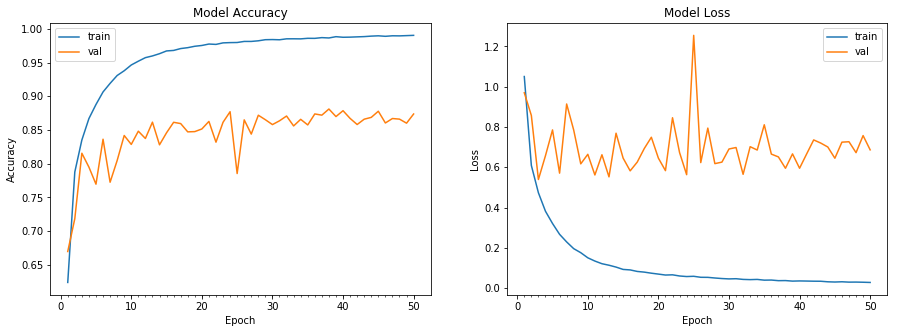

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

train_datagen = ImageDataGenerator(featurewise_center = True, 
                                   featurewise_std_normalization = True,
                                   rotation_range = 10,
                                   zoom_range = 0.10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1)
test_datagen = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
train_datagen.fit(train_features)
test_datagen.fit(test_features)

train_data_iter = train_datagen.flow(train_features,train_labels, batch_size = 128)
test_data_iter =  test_datagen.flow(test_features,test_labels, batch_size = 10000)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

CKPT = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
model_info = model.fit_generator(train_data_iter,
                                 steps_per_epoch = 1000, nb_epoch = 50, 
                                 validation_data = test_data_iter.next(), verbose=1, callbacks = [CKPT])
plot_model_history(model_info)



In [0]:
# compute test accuracy
model.load_weights('./best_model.hdf5')
test_features, test_labels = test_data_iter.next()
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data is: 88.11
